# GSMM mixture modelling with real data

This notebook contains the following processing blocks:
- Gaussian mixture model
- Complex hierarchical gaussian filter
- Complex to real conversion
- Probabilistic Fourier transform
- Observation noise

## Import packages and functions

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/ComplexNormal.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 
;

## Parameters

In [3]:
# data generation parameters
sound_file = "../data/woman.wav"      # specify sound location
fs = 8000                             # specify desired sampling frequency
normalization_method = "max"          # specify normalization method
nr_freqs = 19                         # number of frequencies (excluding DC and fs/2)
nr_clusters = 5                       # number of clusters (needs to be larger than 2 (ForneyLab issue))
bufsize = 2*(nr_freqs+1)              # number of samples in the buffer
stepsize = bufsize                    # step size inbetween buffers
nr_samples = Int(fs/bufsize)          # number of training samples
duration = 5                          # time of testing data

Σ_meas = 1e-10*Ic(bufsize)            # covariance matrix of measurement noise (over time in this case)
Σ_noise = 1e-2
;

## Load and process signals

In [4]:
# load speech data
x_speech, fs_speech = wavread(sound_file, format="native")
fs_speech = Int(fs_speech)
x_speech = convert(Array{Float64,1}, squeeze(x_speech[:,1]))[1*fs_speech:(1+duration)*fs_speech-1]

# pre-process signals
y_speech = preprocess(x_speech, fs_speech)[1:fs] # just 1 second!
y_speech_true = preprocess(x_speech, fs_speech)
y_speech_n = y_speech_true + sqrt(Σ_noise)*randn(size(y_speech_true))

# warp signal and take fft
f_speech = FFTovertime(y_speech, bufsize, bufsize-stepsize, rectangularwindow)
f_speech_n = FFTovertime(y_speech_n, bufsize, bufsize-stepsize, rectangularwindow)

# reduce fft 
fab_speech =  hcat(real.(f_speech[:,1]), 2*real.(f_speech[:,2:nr_freqs+1]), real.(f_speech[:,nr_freqs+2]), -real.(f_speech[:,1]), -2*imag.(f_speech[:,2:nr_freqs+1]), imag.(f_speech[:,nr_freqs+2]))
fab_speech_n =  hcat(real.(f_speech_n[:,1]), 2*real.(f_speech_n[:,2:nr_freqs+1]), real.(f_speech_n[:,nr_freqs+2]), -real.(f_speech_n[:,1]), -2*imag.(f_speech_n[:,2:nr_freqs+1]), imag.(f_speech_n[:,nr_freqs+2]))

# determine corresponding fft frequencies 
fi = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs)[2:end-1]

# get the log abs values
z_speech = log.(abs2.(fab_speech[:,1:nr_freqs+2]) + abs2.(fab_speech[:,nr_freqs+3:end]))
z_speech_n = log.(abs2.(fab_speech_n[:,1:nr_freqs+2]) + abs2.(fab_speech_n[:,nr_freqs+3:end]))

# create time axis
t = collect(0:length(y_speech_n)-1)/fs

# create audioplayers for signals
audioplayers(y_speech, y_speech_n, fs=fs)
;

<source src="data:audio/wav;base64,UklGRjx9AABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB9AAAtgQm+mdpevuqHLb784A2+HAnVvfu9cL3OJj49I9ADPs5eWj5KxJc+b2m6PnjRtz5OIrI+jaGVPp3i6T2k2te8S9wXvbB9nb1UzXO+EyCQvjqJLb4oopS9N8eRvUyiC71LCBY90cGjPUIFNT0z4p4767phvfVWq70zK9e9VI0RvpMRSb6uSka+aHEQvjsiz71hGqy9yX6PvIH/3z1kO10+n0yLPjLPqT5v/r0+zZ+8PlgHoT4LbRQ+hkHou0MDJL3JGJG9/49vvhclnL5cTFm+/jiuvVDdpb3/1469AfguPPZ6sz2ayI893XgaPVQembvC9Ta9uxvAvfFJ+r2y3zG+awZNvuuwL74wvAG+OV++vfL2Kby0iwU+HD18PiglmT558LY+i9fOPmthwj4EkVc+/XkePUXYDjxnAxK9FPdVvjsvr77PeYW+UPIPviDJA77M9g2+mQ8Tvchaxj0on/M9njhlPezLgzzwNAU9eIOePHi0pr31KzK+Xa87vh3RHL5yCRm+eicSvsYNl73W34c9ZXBCPuzthD6waJg+GmO9Pv59yD7L5pM+1yWxPekDZzltrqo7lezavbgMnr5JxKa+ootJvrVvF767Fi++AxvovQ2Z1zttj5E9AX6MPZ3qFD1CnwU8OAhpPMLiRzzpCKO9IkEhvosA772otjK97PFBvU9VT7thVyg+LkWgPhjMqj4M6K8+v4iYPhAmGz7iFZ49GtZJPebE7r3lXpm+gTKHvnGrN75pGFO+vXxhvlTExr0iUxc9N+GtPaKl4D1Vd+09qL+VPRP7gD2Sl3I9clsYvctKOL7vmT2+qCH/vWx/K77QMGG+2e4Avp6RRDxzBG097m+xPdjUMD5SEHk+YkJ6PvCUSj7KNyg+OTryPch0ij0viwq8W4dhvWW1bL21/Km9hIQdvo2bG77Qab+9zLezva9H3r09tXO9HDk3POdZN7puRSm9Ew87vTHa3rw61be8Dp6pvJVML7ukvVE9sTwRPugKZD6p7Ik+4e6hPmr0sz45ClM+2cYyPKtg0jtSYao8m6M/vl8DtL7Lp2e+MjbSvTKfO77JU1O+/GPFvEKh/T0E/fQ9CDDSPa8vIz4QvD0+Vc0aPk8Phj1FE5q8iE6ivUF1v73E7gG+VPw+vubNPr73GN29TE9rvVdbf72lbAG9gk4SPduKkT1Bmzk9/U0PPdBjGz1IWO48PmiXvKZ3UL1tjzO9z2bkvCwaDL1gJCG9wgoIveOQcbwn4ck7xNEBPEjBQ7s52QK7oJpkPKJ9bDt7R7i8MAgRvd4KX7wN7Va89XmhvJqDOjunAPY87eIKPWcGGj3ITFc9x2R8PfYaez1b+y09gB3yPMbZpTzcrXI8/QSBvDjtM71pbz+9/KNCvYfJi72m+Zi9G5FjvTRSS708GVK9nWAnvei8sLxjF6O8H6BRvDZmGzoqGUs8mgaePMm/Nj2HxoE9l9aCPY3vmj1m6809IQPHPWUWoj2JQGg9atspPboFiDzGALq8giCDvZmz0b3OGvC961HxvXwMAL5xzQy+G0PfvYx3mb2SDnK980MwvXcLSrwWDB48sg/hPGYSMD2Sq1U9lvqVPTv87j0vJhY+lgIuPrCPPz4CATM+vnzuPXuJmz393ig95tduvSJwD76sMR++iLwivnePWr7r52K+kFgivi8C572K/t69U5KYvQOky7s8AuU8T8gaPS84eT1cPME94CPiPQVz+T1xbh8+D/1JPt19aj7OsVo+WCLYPS3B0TwBZEk9/raVPDjeC75TP0a+SPC5vfObwb2jBEa+Uz8dvnkcnbyE6x68m0c4vW8iAT0nqds9Tc2kPSlGPj0eKJQ9lLeCPS0Un7uMcSS9U+IBvdOWZ71bz8C9VEy+vS5Ppr2UQ5m9PA+AvQ3aJ70npZO8Vrc/vKTda7x+/sG7LQAhPEqhbTyGwu+78YOOu/MqJDx/2io6y+V3vM/5zTou03M7Uu9vvMcFkrzdGSu8ogMbvMAe/rsRig66qfnWOyse2TtSHjI8ApYXPAiswDyMnh89pSH5PB+DijxgdME8etgHPYgKojxx1ok8RwjNPKjViTxrAJg6WN/TOXrhRruMUhC8kDoKvL74F7wPvOy7hosfvF2Lg7t31266dN/XukQuxzsFmtE7tWblOztRojzxhpk8JcAXPHJ3vTzNYOI8Ty0rPKii8ztNz8o8Av3FPLRvJTzjMwk8osdEO7JHmjrGT408+A+xO6umerwo2NA6/imHPJh6Wro+dbu7gir5O7oBpDqTK6w7OOgdPFy1IDuCgRY7zgZPPMY5czyrVBA7UtgJPARuQjyykzI8s9+3PIgixro4LIo8ixTpPHTPyDvdnKI8lqyUPMjzj7t0HWA8E1m7PAcZsbsb54e8BZMUO7wiEbxr5Tu8kDqHO3D89bt19x6714AnPPv1zrzcSC+8dVcIPd0JHDzTUBe9PLGbvAKMFj0H/Mo7bt0wvSL5dzxpC6s8ANo6vS3cGDxRqgk916EuvcLTFL0ZQOU84CgavDplOb3ISb68cOBTOkyMzLxT11a8/kR6vCOz5LyWFO07H1dXPLoyPL3J25O80wfmPJYTlbykCvu8BVxUO0CvS7o6i5+8iRSSvBcSvTsUOUO8sDznvD0pSrxUnYi76stzvMg+67y2lk+85zQfvNskXbw4ngu8bU+huxEPbbqybjy70xVau39eELsJBoQ7KTFZuiBD7rus8pi60RnJun9oMrrNEfa7xYjluy+9qrtAil67tOrKOi4Vijp3odS46MhTO+Sfszsxm4W7Ho5Vu3qyZLsK7A684q8qvMaRHLzTxQG8GERivKouZ7yV1RG8YZZ7u0Wd+boPcV+7EIPNO5OaNTyLJdU74lKJOy+nBTzgWsg7JwUZO6fQZDv6Qpo6b1OOOUkeaTqYxXm6qNB+ukDdAbtLekQ5o0UnO+XBQrvSxsK7qUPIuzfABrxO6QC8BHYMvDqMk7sq7NO5DdZMO06pnjsJqKi5+C6POw1RDTy/yc87z2/euUxdDjvzD+w7oEoROy8CNrsN0mc7b9DVOy1NbzvdYom6MNKJO2McwTvBSvI7PFUIPAP1ODwXMjE8ybwnPArNLzzjEv47/e8BPGykAzwQ9h47hx6VO968wDvLGwY82fI2PIKI8DvhO+c7T70DPAyo5TsYm8g778rRO/qrMzw3EBs8+2GROyLa5ju/jQ48VnXpOxAxWzy3+3E8hW0sPHZxCTw7sjY8Y2O2Ow23dTt/abM7Bnhau0khsru8fvq75BCHu0oTq7uJcmC7DBJTO/sWYjvB+SE6XWz+OktJLjvRvSi6Xre5u+8c5rtyqiS83b0bvOP3RLw1EoK88GiNvNPUcrymQIm8VwWRvPoeSbzeE228V6yAvI7AhLx9CXq876qWvPv/n7zyLJy86h2xvGQIpbzu+KK8VC+ZvGiSsrxJh2e8uM5HvEU3ibw/CVa8d95RvFz0MLzbCHy8GSucvH20nLwMj5i84cVzvFJ4f7z8mHi8485wvL60aLzb14e86QmPvO5narzQvDC84YZ0vMygWbwpsxy8VUcRvHTEGbzC+He77af/u6r8Jryd/Om7SQt1u+2Yi7u5fmq7BcTWu1ReObvJAMW3gLwDu24/rjqi+Uc6yJEjO4fBWjtl5Xk6TjE8O160NjslvKu74dccuqDRbTpiyeE6YXGSOqgqcTsH8d07eouEO50qvjv+zys8ilgFPHjzRTxUpGY86SQgPAU2OTwNQwU8UPYxPBg7EDx2kho8OZs/PJL/6jsqY+o7ExwbPFoIWTyZoxY8Js42PJZ2cTznyS48fdwIPGmOTDypE2c8a4yDPPdmeDyNL208nHliPICEkzyubYc8Qo0+PB/6OTwSD

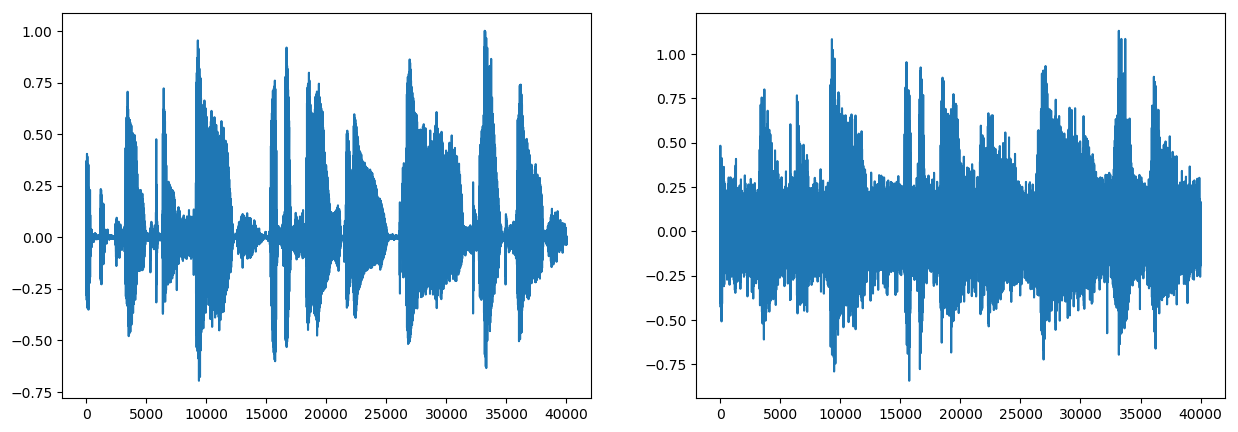

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000061403780>

In [5]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true)
ax[2].plot(y_speech_n)

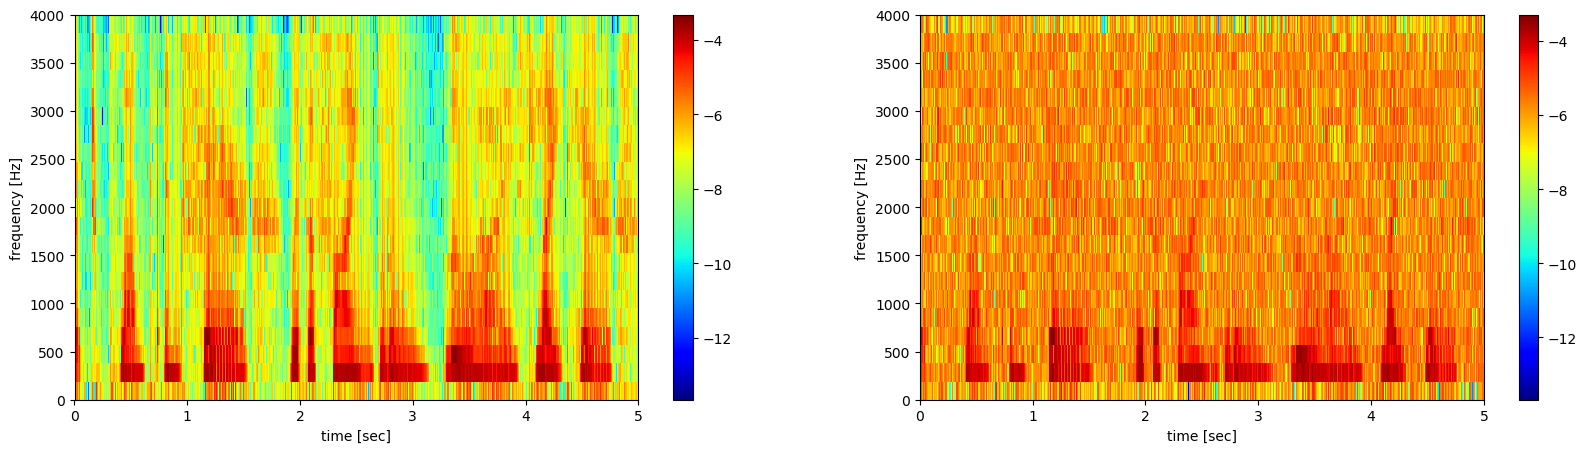

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[2], colorbar=true)
;

## Train GSMM through K-means and EM

In [7]:
# perform clustering (ignore DC and fs/2)
g = GMM(nr_clusters, z_speech[:,2:end-1], nIter=50, nInit=100, kind=:diag)
em!(g, z_speech[:,2:end-1])
;

┌ Info: Initializing GMM, 5 Gaussians diag covariance 19 dimensions using 200 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.721854e+04
      1       9.891925e+03      -7.326617e+03 |        5
      2       9.657925e+03      -2.340002e+02 |        5
      3       9.516489e+03      -1.414356e+02 |        5
      4       9.453130e+03      -6.335918e+01 |        3
      5       9.427192e+03      -2.593819e+01 |        3
      6       9.359286e+03      -6.790616e+01 |        3
      7       9.274009e+03      -8.527696e+01 |        4
      8       9.215173e+03      -5.883589e+01 |        4
      9       9.167263e+03      -4.790969e+01 |        5
     10       9.068703e+03      -9.855989e+01 |        3
     11       9.020279e+03      -4.842407e+01 |        3
     12       8.972817e+03      -4.746194e+01 |        2
     13       8.952680e+03      -2.013737e+01 |        3
     14       8.901918e+03      -5.076162e+01 |        3
     15       8.878444e+03      -2.347369e+01 |        

┌ Info: K-means with 200 data points using 18 iterations
│ 2.0 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139


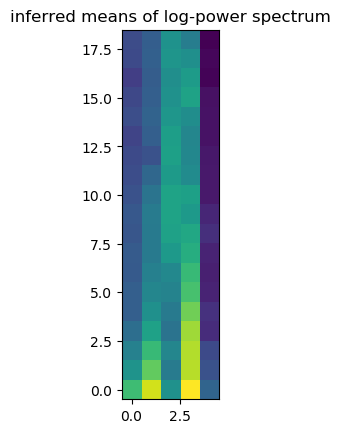

In [8]:
plt.imshow(g.μ', origin="lower")
plt.title("inferred means of log-power spectrum");

## Train GSMM through variational message passing on a factor graph

### Step 1: Build factor graph

In [9]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars = Dict()

# specify distribution over the selection variables
@RV vars[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(nr_clusters,)))

# create mixture components
for k = 1:nr_clusters
    
    # specify distribution over precision matrix
    @RV vars[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars[pad(:w,k)])
    
end

# create sample-dependent random variables
for k = 1:nr_samples
    
    # specify distribution over selection variable
    @RV vars[pad(:z,k)] ~ Categorical(vars[:π])
    
    # create gaussian mixture model
    @RV vars[pad(:ξ,k)] ~ GaussianMixture(vars[pad(:z,k)], expand([[vars[pad(:m,ki)], vars[pad(:w,ki)]] for ki=1:nr_clusters])...)
    
    # log-power to complex fourier coefficients transform
    @RV vars[pad(:Xc,k)] ~ ComplexHGF(vars[pad(:ξ,k)])

    # complex fourier coefficients to real and imaginary parts concatenated
    @RV vars[pad(:Xr,k)] ~ ComplexToReal(vars[pad(:Xc,k)])
    
    # probabilistic Fourier transform
    @RV vars[pad(:x,k)] = placeholder(pad(:C,k), dims=(bufsize, 2*(nr_freqs)))*vars[pad(:Xr,k)]
    
    # observation model 
    @RV vars[pad(:y,k)] ~ GaussianMeanVariance(vars[pad(:x,k)], Σ_meas)
    
    # observation
    placeholder(vars[pad(:y,k)], :y, index=k, dims=(bufsize,))
    
end

# draw graph
if nr_samples == 1
    ForneyLab.draw(fg)
end
;

### Step 2: Generate inference algorithm

In [10]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:nr_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars[:π], 
                           expand([[vars[pad(:m,k)], vars[pad(:w,k)]] for k=1:nr_clusters])...,
                           [vars[pad(:z,k)] for k=1:nr_samples],
                           [vars[pad(:Xc,k)] for k=1:nr_samples],
                           [vars[pad(:ξ,k)] for k=1:nr_samples],
                           ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: create data and marginals dictionary

In [11]:
y_samples = [y_speech[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(y_speech)/bufsize)];
y_samples_n = [y_speech_n[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(y_speech_n)/bufsize)];
t_samples = [t[(k-1)*bufsize+1:k*bufsize] for k = 1:Int(length(t)/bufsize)];
;

In [12]:
# create data dictionary
data = Dict()

# specify input data and measurement noise
data[:y] = y_samples

# specify priors over class probabilities
data[:α_π] = 1.0*ones(nr_clusters)

# specify priors over clusters
for k = 1:nr_clusters
    data[pad(:μ_m,k)] = g.μ[k,:]
    data[pad(:nu_w,k)] = (nr_freqs)
    data[pad(:V_w,k)] = diagm(1 ./g.Σ[k,:]) / (nr_freqs)
end

# specify probabilistic fourier matrices
for k = 1:nr_samples
    data[pad(:C,k)] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples[k]')', sin.(2*pi*fi*t_samples[k]')')
end
;

In [13]:
# create marginals dictionary
marginals = Dict()

# specify marginals over class probabilities
marginals[:vars_π] = vague(ForneyLab.Dirichlet, nr_clusters)

# specify marginals over clusters
for k = 1:nr_clusters
    marginals[pad(:vars_m,k)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,k)], w=data[pad(:V_w,k)]*data[pad(:nu_w,k)])
    marginals[pad(:vars_w,k)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,k)], nu=data[pad(:nu_w,k)])
end

# specify marginals over samples
for k = 1:nr_samples
    marginals[pad(:vars_z,k)] = ProbabilityDistribution(Categorical, p=weights(g))
    marginals[pad(:vars_Xc,k)] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[pad(:vars_ξ,k)] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(nr_freqs), v=10*Ic(nr_freqs))
end
; 

### Step 4: Perform inference

In [14]:
# set number of iterations
nr_its = 10

# create progress bar
p = Progress(nr_its)

# perform iterations
for i = 1:nr_its
    
    # perform updates
    stepXc!(data, marginals)
    stepΞ!(data, marginals)
    stepZ!(data, marginals)
    stepΠ!(data, marginals) 
    for k = 1:nr_clusters
        getfield(Main, Symbol("stepM_"*string(k,pad=2)*"!"))(data, marginals)
        getfield(Main, Symbol("stepW_"*string(k,pad=2)*"!"))(data, marginals)
    end
    
    # update progress bar
    next!(p)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:19:18


### Step 5: Analyze results

In [15]:
# get inferred cluster assignments and print confusion matrix
z_train_em = [findmax(llpg(g, z_speech[:,2:end-1])[k,:])[2] for k = 1:g.nx];
z_train_inf = [findmax(marginals[pad(:vars_z,k)].params[:p])[2] for k = 1:nr_samples];

# get clusters with zero assignments
remaining_clusters = unique(z_train_inf)
rm_clusters = length(remaining_clusters)

# plot confusion matrix
confusionmatrix(nr_clusters, z_train_em .- minimum(z_train_em) .+ 1, z_train_inf .- minimum(z_train_inf) .+ 1)

5×5 Array{Int64,2}:
 55   0   0   0   0
  5  30   0   0   0
  3   3  19   0   0
  0   4   0  31   0
  7   0   0   0  43

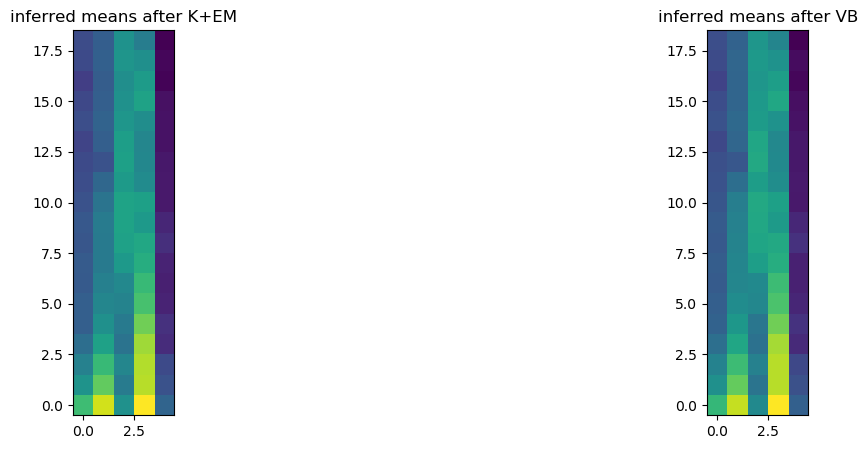

PyObject Text(0.5, 1.0, 'inferred means after VB')

In [16]:
# get new means and variances of remaining clustersand show results
μ_trained = []
V_trained = []
nu_trained = []
for k = 1:nr_clusters
    if k in remaining_clusters
        push!(μ_trained, ForneyLab.unsafeMean(marginals[pad(:vars_m,k)]))
        push!(V_trained, marginals[pad(:vars_w,k)].params[:v])
        push!(nu_trained, marginals[pad(:vars_w,k)].params[:nu])
    end
end

# get new dirichlet prior
ps = marginals[:vars_π].params[:a]

# plot new and previous means
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].imshow(g.μ', origin="lower")
ax[1].set_title("inferred means after K+EM")
ax[2].imshow(hcat(μ_trained...), origin="lower")
ax[2].set_title("inferred means after VB")


## Perform speech enhancement

### Step 1: build factor graph

In [17]:
# create factor graph
fg = FactorGraph()

# create distionary for variables
vars_e = Dict()

# specify distribution over the selection variables
@RV vars_e[:π] ~ ForneyLab.Dirichlet(placeholder(:α_π, dims=(rm_clusters,)))

# create mixture components
for k = 1:rm_clusters
    
    # specify distribution over precision matrix
    @RV vars_e[pad(:w,k)] ~ Wishart(placeholder(pad(:V_w,k), dims=(nr_freqs,nr_freqs)), placeholder(pad(:nu_w,k)))
    
    # specify distribution over mean
    @RV vars_e[pad(:m,k)] ~ GaussianMeanPrecision(placeholder(pad(:μ_m,k), dims=(nr_freqs,)), vars_e[pad(:w,k)])
    
end

# specify distribution over selection variable
@RV vars_e[:z] ~ Categorical(vars_e[:π])

# create gaussian mixture model
@RV vars_e[:ξ] ~ GaussianMixture(vars_e[:z], expand([[vars_e[pad(:m,ki)], vars_e[pad(:w,ki)]] for ki=1:rm_clusters])...)

# log-power to complex fourier coefficients transform
@RV vars_e[:Xc] ~ ComplexHGF(vars_e[:ξ])

# complex fourier coefficients to real and imaginary parts concatenated
@RV vars_e[:Xr] ~ ComplexToReal(vars_e[:Xc])

# probabilistic Fourier transform
@RV vars_e[:x] = placeholder(:C, dims=(bufsize, 2*(nr_freqs)))*vars_e[:Xr]

# observation model 
@RV vars_e[:y] ~ GaussianMeanVariance(vars_e[:x], Σ_noise*Ic(bufsize))

# observation
placeholder(vars_e[:y], :y, dims=(bufsize,))
   
# draw graph
ForneyLab.draw(fg)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3712789040220692056 -->
 3712789040220692056 
 
 placeholder_nu_w_04 
 
<!-- 1850209399084381771 -->
 1850209399084381771 
 
 placeholder_nu_w_05 
 
<!-- 9606258506056102711 -->
 9606258506056102711 
 
 GM 
 gaussianmixture_1 
 
<!-- 5509285785188805148 -->
 5509285785188805148 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 9606258506056102711--5509285785188805148 -->
 9606258506056102711--5509285785188805148 
 
 vars_e_m_01 
 1 out 
 3 m1 
 
<!-- 14689804921116795641 -->
 14689804921116795641 
 
 Cat 
 categorical_1 
 
<!-- 9606258506056102711--14689804921116795641 -->
 9606258506056102711--14689804921116795641 
 
 vars_e_z 
 1 out 
 2 z 
 
<!-- 11155887993471287816 -->
 11155887993471287816 
 
 𝒩 
 gaussianmeanprecision_5 
 
<!-- 9606258506056102711--11155887993471287816 -->
 9606258506056102711--11155887993471287816 
 
 vars_e_m_05 
 1 out 
 11 m5 
 
<!-- 15104518680569674872 -->
 15104518680569674872 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 9606258506056102711--15104518680569674872 -->
 9606258506056102711--15104518680569674872 
 
 vars_e_m_02 
 1 out 
 5 m2 
 
<!-- 6955988374978363338 -->
 6955988374978363338 
 
 𝒩 
 gaussianmeanprecision_4 
 
<!-- 9606258506056102711--6955988374978363338 -->
 9606258506056102711--6955988374978363338 
 
 vars_e_m_04 
 1 out 
 9 m4 
 
<!-- 893175213855679146 -->
 893175213855679146 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 9606258506056102711--893175213855679146 -->
 9606258506056102711--893175213855679146 
 
 vars_e_m_03 
 1 out 
 7 m3 
 
<!-- 11207335536343478145 -->
 11207335536343478145 
 
 Dir 
 dirichlet_1 
 
<!-- 1254865103386645232 -->
 1254865103386645232 
 
 placeholder_α_π 
 
<!-- 11207335536343478145--1254865103386645232 -->
 11207335536343478145--1254865103386645232 
 
 α_π 
 1 out 
 2 a 
 
<!-- 13134888001734769995 -->
 13134888001734769995 
 
 W 
 wishart_1 
 
<!-- 17384576950215451567 -->
 17384576950215451567 
 
 placeholder_V_w_01 
 
<!-- 13134888001734769995--17384576950215451567 -->
 13134888001734769995--17384576950215451567 
 
 V_w_01 
 1 out 
 2 v 
 
<!-- 15870928453894534248 -->
 15870928453894534248 
 
 placeholder_nu_w_01 
 
<!-- 13134888001734769995--15870928453894534248 -->
 13134888001734769995--15870928453894534248 
 
 nu_w_01 
 1 out 
 3 nu 
 
<!-- 3242576165424296393 -->
 3242576165424296393 
 
 W 
 wishart_5 
 
<!-- 3242576165424296393--1850209399084381771 -->
 3242576165424296393--1850209399084381771 
 
 nu_w_05 
 1 out 
 3 nu 
 
<!-- 3085062967420101429 -->
 3085062967420101429 
 
 placeholder_V_w_05 
 
<!-- 3242576165424296393--3085062967420101429 -->
 3242576165424296393--3085062967420101429 
 
 V_w_05 
 1 out 
 2 v 
 
<!-- 460133459879091996 -->
 460133459879091996 
 
 placeholder_vars_e_y 
 
<!-- 9274679419966911567 -->
 9274679419966911567 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 460133459879091996--9274679419966911567 -->
 460133459879091996--9274679419966911567 
 
 vars_e_y 
 1 out 
 1 out 
 
<!-- 1185343541470750812 -->
 1185343541470750812 
 
 placeholder_V_w_04 
 
<!-- 3000225481248203584 -->
 3000225481248203584 
 
 placeholder_C 
 
<!-- 4059332322792003079 -->
 4059332322792003079 
 
 clamp_1 
 
<!-- 15942186552682458950 -->
 15942186552682458950 
 
 placeholder_μ_m_04 
 
<!-- 10799114221999612231 -->
 10799114221999612231 
 
 ComplexHGF 
 complexhgf_1 
 
<!-- 10799114221999612231--9606258506056102711 -->
 10799114221999612231--9606258506056102711 
 
 vars_e_ξ 
 1 out 
 2 ξ 
 
<!-- 4470798857197012231 -->
 4470798857197012231 
 
 placeholder_μ_m_01 
 
<!-- 550928578518880

### Step 2: Generate inference algorithm

In [18]:
# specify ids for the posterior factorization
q_ids = vcat(:Π,
              expand([[pad(:M,k), pad(:W,k)] for k=1:rm_clusters]),
              :Z, :Xc, :Ξ)

# specify posterior factorization
q = PosteriorFactorization(vars_e[:π], 
                           expand([[vars_e[pad(:m,k)], vars_e[pad(:w,k)]] for k=1:rm_clusters])...,
                           vars_e[:z], vars_e[:Xc], vars_e[:ξ], ids=q_ids)

# generate the inference algorithm
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo)

# Load algorithm
eval(Meta.parse(source_code))
;

### Step 3: inference

In [19]:
# prevent posdef errors (Marco his comment on ForneyLab issue #86)
function safeChol(A::Hermitian)
    # `safeChol(A)` is a 'safe' version of `chol(A)` in the sense
    # that it adds jitter to the diagonal of `A` and tries again if
    # `chol` raised a `PosDefException`.
    # Matrix `A` can be non-positive-definite in practice even though it
    # shouldn't be in theory due to finite floating point precision.
    # If adding jitter does not help, `PosDefException` will still be raised.
    L = similar(A)
    try
        L = cholesky(A)
        catch #Base.LinAlg.PosDefException
        # Add jitter to diagonal to break linear dependence among rows/columns.
        # The additive noise is input-dependent to make sure that we hit the
        # significant precision of the Float64 values with high probability.
        jitter = Diagonal(1e-13*(rand(size(A,1))) .* diag(A))
        L = cholesky(A + jitter)
    end
end
ForneyLab.unsafeMean(dist::ProbabilityDistribution{Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]
unsafeMean(dist::ProbabilityDistribution{Multivariate, GaussianWeightedMeanPrecision}) = inv(safeChol(Hermitian(dist.params[:w])))*dist.params[:xi]

unsafeMean (generic function with 16 methods)

In [50]:
# create placeholders
ξ_inferred = Array{Float64, 2}(undef, nr_samples*duration, nr_freqs)
x_inferred = Array{Float64, 2}(undef, nr_samples*duration, bufsize)

# loop through segments
@showprogress for k = 1:nr_samples*duration
    
    # set number of iterations
    nr_its = 10

    # create data dictionary
    data = Dict()

    # specify input data and measurement noise
    data[:y] = y_samples_n[k] .- mean(y_samples_n[k])

    # specify priors over class probabilities
    data[:α_π] = ps

    # specify priors over clusters
    for ki = 1:rm_clusters
        data[pad(:μ_m,ki)] = μ_trained[ki]
        data[pad(:nu_w,ki)] = nu_trained[ki]
        data[pad(:V_w,ki)] =  V_trained[ki]
    end

    # specify probabilistic fourier matrices
    data[:C] = 1/bufsize*hcat(cos.(2*pi*fi*t_samples[k]')', sin.(2*pi*fi*t_samples[k]')')
    

    # create marginals dictionary
    marginals = Dict()

    # specify marginals over class probabilities
    marginals[:vars_e_π] = ProbabilityDistribution(ForneyLab.Dirichlet, a=ps)

    # specify marginals over clusters
    for ki = 1:rm_clusters
        marginals[pad(:vars_e_m,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(:μ_m,ki)], w=data[pad(:V_w,ki)]*data[pad(:nu_w,ki)])
        marginals[pad(:vars_e_w,ki)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(:V_w,ki)], nu=data[pad(:nu_w,ki)])
    end
    
    # specify marginals over samples
    #marginals[:vars_e_z] = vague(Categorical)
    #marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=ps/sum(ps))
    marginals[:vars_e_z] = ProbabilityDistribution(Categorical, p=exp.(ps)/sum(exp.(ps))) # not sure whether best way
    marginals[:vars_e_Xc] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=(1e10)*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
    marginals[:vars_e_ξ] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=z_speech_n[k,2:end-1], v=1.0*diagm(squeeze(var(z_speech_n[:,2:end-1], dims=1))))
                    
    # perform iterations
    for i = 1:nr_its

        # perform updates
        stepXc!(data, marginals)
        stepΞ!(data, marginals)
        stepZ!(data, marginals)
        
    end
    try
        ξ_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_ξ])
        x_inferred[k,:] = ForneyLab.unsafeMean(marginals[:vars_e_x]) .+ mean(y_samples_n[k])
    catch
        ξ_inferred[k,:] = zeros(nr_freqs)
        x_inferred[k,:] = zeros(bufsize)
        println("Posdef Exception, k="*string(k))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


### Step 4: results

In [51]:
# reshape enhance speech signal
y_enhanced = vcat(x_inferred'...)
;

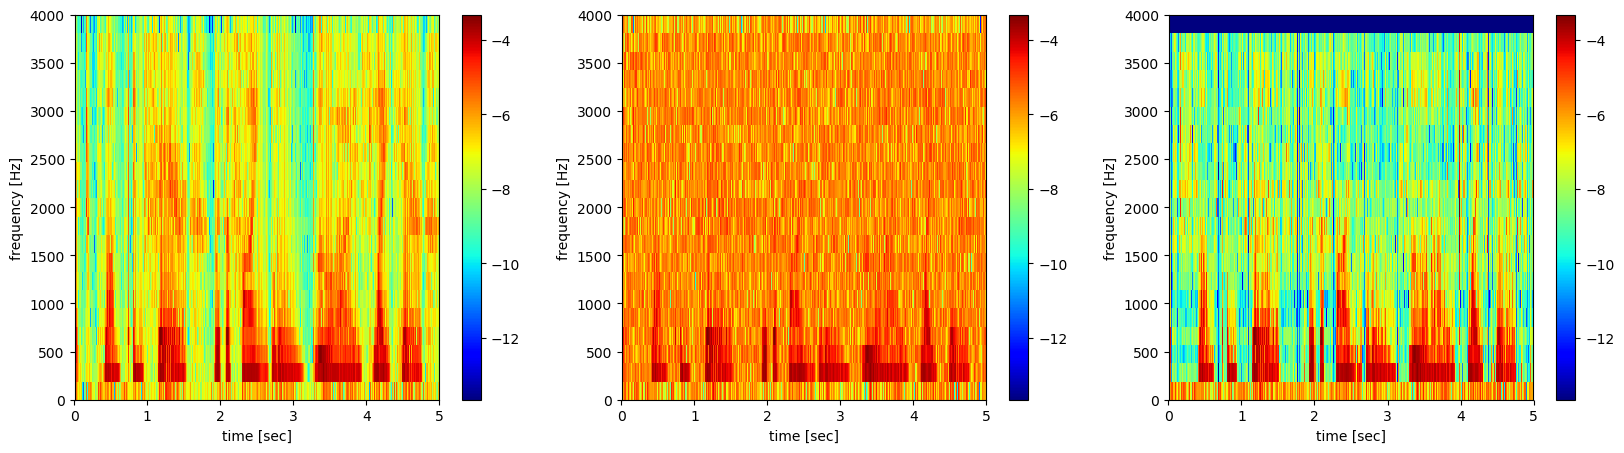

In [52]:
#plt.imshow(ξ_inferred',origin="lower", aspect="auto"), plt.colorbar()
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
cmp = plot_spectrogram(spectrogram(y_speech_true, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[1], colorbar=true)
plot_spectrogram(spectrogram(y_speech_n, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[2])
plot_spectrogram(spectrogram(y_enhanced, bufsize, bufsize-stepsize, fs=fs), fs, ax=ax[3])
vrange = ax[1].get_images()[1].get_clim()
fig.colorbar(cmp, ax=ax[2])
ax[2].get_images()[1].set_clim(vrange)
fig.colorbar(cmp, ax=ax[3])
ax[3].get_images()[1].set_clim(vrange)
;

<source src="data:audio/wav;base64,UklGRjxxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQBxAgAtgQm+mdpevuqHLb784A2+HAnVvfu9cL3OJj49I9ADPs5eWj5KxJc+b2m6PnjRtz5OIrI+jaGVPp3i6T2k2te8S9wXvbB9nb1UzXO+EyCQvjqJLb4oopS9N8eRvUyiC71LCBY90cGjPUIFNT0z4p4767phvfVWq70zK9e9VI0RvpMRSb6uSka+aHEQvjsiz71hGqy9yX6PvIH/3z1kO10+n0yLPjLPqT5v/r0+zZ+8PlgHoT4LbRQ+hkHou0MDJL3JGJG9/49vvhclnL5cTFm+/jiuvVDdpb3/1469AfguPPZ6sz2ayI893XgaPVQembvC9Ta9uxvAvfFJ+r2y3zG+awZNvuuwL74wvAG+OV++vfL2Kby0iwU+HD18PiglmT558LY+i9fOPmthwj4EkVc+/XkePUXYDjxnAxK9FPdVvjsvr77PeYW+UPIPviDJA77M9g2+mQ8Tvchaxj0on/M9njhlPezLgzzwNAU9eIOePHi0pr31KzK+Xa87vh3RHL5yCRm+eicSvsYNl73W34c9ZXBCPuzthD6waJg+GmO9Pv59yD7L5pM+1yWxPekDZzltrqo7lezavbgMnr5JxKa+ootJvrVvF767Fi++AxvovQ2Z1zttj5E9AX6MPZ3qFD1CnwU8OAhpPMLiRzzpCKO9IkEhvosA772otjK97PFBvU9VT7thVyg+LkWgPhjMqj4M6K8+v4iYPhAmGz7iFZ49GtZJPebE7r3lXpm+gTKHvnGrN75pGFO+vXxhvlTExr0iUxc9N+GtPaKl4D1Vd+09qL+VPRP7gD2Sl3I9clsYvctKOL7vmT2+qCH/vWx/K77QMGG+2e4Avp6RRDxzBG097m+xPdjUMD5SEHk+YkJ6PvCUSj7KNyg+OTryPch0ij0viwq8W4dhvWW1bL21/Km9hIQdvo2bG77Qab+9zLezva9H3r09tXO9HDk3POdZN7puRSm9Ew87vTHa3rw61be8Dp6pvJVML7ukvVE9sTwRPugKZD6p7Ik+4e6hPmr0sz45ClM+2cYyPKtg0jtSYao8m6M/vl8DtL7Lp2e+MjbSvTKfO77JU1O+/GPFvEKh/T0E/fQ9CDDSPa8vIz4QvD0+Vc0aPk8Phj1FE5q8iE6ivUF1v73E7gG+VPw+vubNPr73GN29TE9rvVdbf72lbAG9gk4SPduKkT1Bmzk9/U0PPdBjGz1IWO48PmiXvKZ3UL1tjzO9z2bkvCwaDL1gJCG9wgoIveOQcbwn4ck7xNEBPEjBQ7s52QK7oJpkPKJ9bDt7R7i8MAgRvd4KX7wN7Va89XmhvJqDOjunAPY87eIKPWcGGj3ITFc9x2R8PfYaez1b+y09gB3yPMbZpTzcrXI8/QSBvDjtM71pbz+9/KNCvYfJi72m+Zi9G5FjvTRSS708GVK9nWAnvei8sLxjF6O8H6BRvDZmGzoqGUs8mgaePMm/Nj2HxoE9l9aCPY3vmj1m6809IQPHPWUWoj2JQGg9atspPboFiDzGALq8giCDvZmz0b3OGvC961HxvXwMAL5xzQy+G0PfvYx3mb2SDnK980MwvXcLSrwWDB48sg/hPGYSMD2Sq1U9lvqVPTv87j0vJhY+lgIuPrCPPz4CATM+vnzuPXuJmz393ig95tduvSJwD76sMR++iLwivnePWr7r52K+kFgivi8C572K/t69U5KYvQOky7s8AuU8T8gaPS84eT1cPME94CPiPQVz+T1xbh8+D/1JPt19aj7OsVo+WCLYPS3B0TwBZEk9/raVPDjeC75TP0a+SPC5vfObwb2jBEa+Uz8dvnkcnbyE6x68m0c4vW8iAT0nqds9Tc2kPSlGPj0eKJQ9lLeCPS0Un7uMcSS9U+IBvdOWZ71bz8C9VEy+vS5Ppr2UQ5m9PA+AvQ3aJ70npZO8Vrc/vKTda7x+/sG7LQAhPEqhbTyGwu+78YOOu/MqJDx/2io6y+V3vM/5zTou03M7Uu9vvMcFkrzdGSu8ogMbvMAe/rsRig66qfnWOyse2TtSHjI8ApYXPAiswDyMnh89pSH5PB+DijxgdME8etgHPYgKojxx1ok8RwjNPKjViTxrAJg6WN/TOXrhRruMUhC8kDoKvL74F7wPvOy7hosfvF2Lg7t31266dN/XukQuxzsFmtE7tWblOztRojzxhpk8JcAXPHJ3vTzNYOI8Ty0rPKii8ztNz8o8Av3FPLRvJTzjMwk8osdEO7JHmjrGT408+A+xO6umerwo2NA6/imHPJh6Wro+dbu7gir5O7oBpDqTK6w7OOgdPFy1IDuCgRY7zgZPPMY5czyrVBA7UtgJPARuQjyykzI8s9+3PIgixro4LIo8ixTpPHTPyDvdnKI8lqyUPMjzj7t0HWA8E1m7PAcZsbsb54e8BZMUO7wiEbxr5Tu8kDqHO3D89bt19x6714AnPPv1zrzcSC+8dVcIPd0JHDzTUBe9PLGbvAKMFj0H/Mo7bt0wvSL5dzxpC6s8ANo6vS3cGDxRqgk916EuvcLTFL0ZQOU84CgavDplOb3ISb68cOBTOkyMzLxT11a8/kR6vCOz5LyWFO07H1dXPLoyPL3J25O80wfmPJYTlbykCvu8BVxUO0CvS7o6i5+8iRSSvBcSvTsUOUO8sDznvD0pSrxUnYi76stzvMg+67y2lk+85zQfvNskXbw4ngu8bU+huxEPbbqybjy70xVau39eELsJBoQ7KTFZuiBD7rus8pi60RnJun9oMrrNEfa7xYjluy+9qrtAil67tOrKOi4Vijp3odS46MhTO+Sfszsxm4W7Ho5Vu3qyZLsK7A684q8qvMaRHLzTxQG8GERivKouZ7yV1RG8YZZ7u0Wd+boPcV+7EIPNO5OaNTyLJdU74lKJOy+nBTzgWsg7JwUZO6fQZDv6Qpo6b1OOOUkeaTqYxXm6qNB+ukDdAbtLekQ5o0UnO+XBQrvSxsK7qUPIuzfABrxO6QC8BHYMvDqMk7sq7NO5DdZMO06pnjsJqKi5+C6POw1RDTy/yc87z2/euUxdDjvzD+w7oEoROy8CNrsN0mc7b9DVOy1NbzvdYom6MNKJO2McwTvBSvI7PFUIPAP1ODwXMjE8ybwnPArNLzzjEv47/e8BPGykAzwQ9h47hx6VO968wDvLGwY82fI2PIKI8DvhO+c7T70DPAyo5TsYm8g778rRO/qrMzw3EBs8+2GROyLa5ju/jQ48VnXpOxAxWzy3+3E8hW0sPHZxCTw7sjY8Y2O2Ow23dTt/abM7Bnhau0khsru8fvq75BCHu0oTq7uJcmC7DBJTO/sWYjvB+SE6XWz+OktJLjvRvSi6Xre5u+8c5rtyqiS83b0bvOP3RLw1EoK88GiNvNPUcrymQIm8VwWRvPoeSbzeE228V6yAvI7AhLx9CXq876qWvPv/n7zyLJy86h2xvGQIpbzu+KK8VC+ZvGiSsrxJh2e8uM5HvEU3ibw/CVa8d95RvFz0MLzbCHy8GSucvH20nLwMj5i84cVzvFJ4f7z8mHi8485wvL60aLzb14e86QmPvO5narzQvDC84YZ0vMygWbwpsxy8VUcRvHTEGbzC+He77af/u6r8Jryd/Om7SQt1u+2Yi7u5fmq7BcTWu1ReObvJAMW3gLwDu24/rjqi+Uc6yJEjO4fBWjtl5Xk6TjE8O160NjslvKu74dccuqDRbTpiyeE6YXGSOqgqcTsH8d07eouEO50qvjv+zys8ilgFPHjzRTxUpGY86SQgPAU2OTwNQwU8UPYxPBg7EDx2kho8OZs/PJL/6jsqY+o7ExwbPFoIWTyZoxY8Js42PJZ2cTznyS48fdwIPGmOTDypE2c8a4yDPPdmeDyNL208nHliPICEkzyubYc8Qo0+PB/6OTwSD

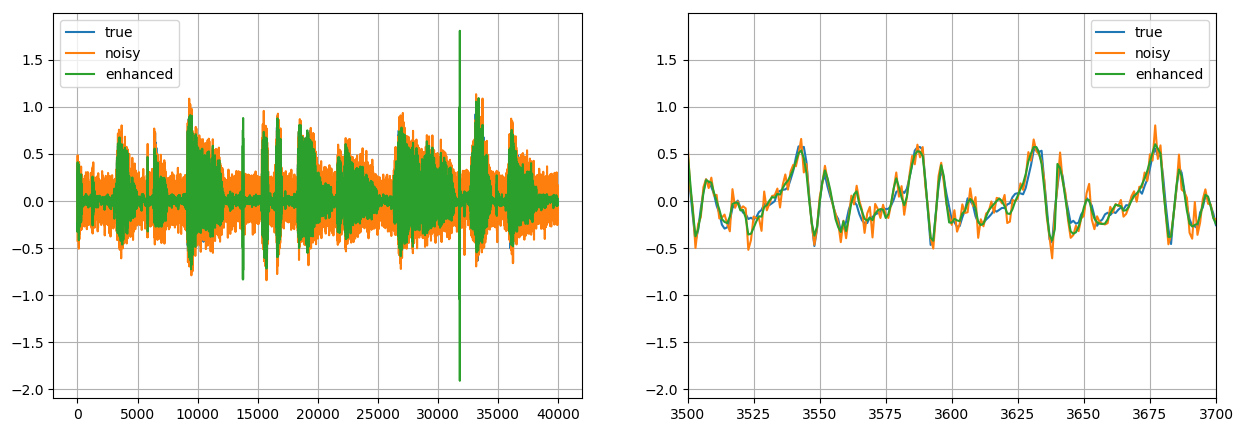

In [53]:
# plot signals
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(y_speech_true, label="true")
ax[1].plot(y_speech_n, label="noisy")
ax[1].plot(y_enhanced, label="enhanced")
ax[2].plot(y_speech_true, label="true")
ax[2].plot(y_speech_n, label="noisy")
ax[2].plot(y_enhanced, label="enhanced")
ax[1].grid(), ax[2].grid(), ax[2].set_xlim([3500, 3700]), ax[1].legend(), ax[2].legend()
audioplayers(y_speech_true, y_speech_n, y_enhanced, fs=fs)

In [54]:
mean(abs2.(y_speech_true - y_speech_n)), mean(abs2.(y_speech_true - y_enhanced))

(0.009888628237385387, 0.0031961670178009723)